In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

In [3]:
df = pd.read_csv('gas_price_data.txt', delimiter='\t', header=0) 
# rename first column to 'date'
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
# this is weekly gas price data 

df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'gas_price_data.txt'

In [ ]:
# our goal is to convert the dates to a number so that we can construct some models 
df['Date'] = pd.to_datetime(df['Date']) 

/var/folders/4x/0dy7fsg94_sfgtkk4pdx97c00000gn/T/ipykernel_1760/3125743347.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [ ]:
df.head()

,Date,Regular,Diesel
0,2022-08-29,3.85,5.06
1,2022-09-05,3.79,5.07
2,2022-09-12,3.72,5.01
3,2022-09-19,3.68,4.95
4,2022-09-26,3.73,4.90


In [ ]:
# fill in the missing values 
df_augmented = df.set_index('Date').resample('D').asfreq().reset_index() # 'D' = days; your data in years!
df_augmented[0:10] #

,Date,Regular,Diesel
0,2022-08-29,3.85,5.06
1,2022-08-30,NaN,NaN
2,2022-08-31,NaN,NaN
3,2022-09-01,NaN,NaN
4,2022-09-02,NaN,NaN
5,2022-09-03,NaN,NaN
6,2022-09-04,NaN,NaN
7,2022-09-05,3.79,5.07
8,2022-09-06,NaN,NaN
9,2022-09-07,NaN,NaN


The index serves as a numerical encoding of the date. So 5 represents Sept 3, 2022. 

Next, I want to fill in the missing values based on the known values. How do we do this with a linear function? 

In [ ]:
def fill_missing_values_with_local_linear_function(x:np.array, y:np.array, x_approx:float) -> float: 
    """Returns approximate y value using a local linear function
    
    Parameters: 
        x (np.array): x values
        y (np.array): y values
        x_approx (float): x value to approximate

    Returns:
        float: y_approx (float)
    """

    # find the closest point above x_approx
    x_above_vals = np.sort(x[np.where(x - x_approx > 0)])
    x_above = x_above_vals[0]
    y_above = y[np.where(x == x_above)][0]

    # find the closest point below x_approx
    x_below_vals = np.sort(x[np.where(x - x_approx < 0)])
    x_below = x_below_vals[-1]
    y_below = y[np.where(x == x_below)][0]

    # compute the slope
    slope = (y_above - y_below) / (x_above - x_below)

    # compute the y-intercept
    y_intercept = y_below - slope * x_below

    # compute the missing value
    y_approx = slope * x_approx + y_intercept
    
    return y_approx


``regular_prices`` contains all the known prices we have in our dataset. We need to identify their x-values. If the price isn't known, the dataframe as "NaN" meaning it is missing. ``isnull()`` is a method to find those cases. Their indexes are the x-values we want. 

If it is NOT null, we can use the symbol ``~`` to mean "not" and get everything else. 

In [ ]:
y_values = df['Regular'].values # y-vals are the known regular gas prices 

# missing values 
missing_values = df_augmented[df_augmented['Regular'].isnull()].index

# known x values index
x_values = df_augmented[~df_augmented['Regular'].isnull()].index

print('missing values:', missing_values)
print('known values:', x_values)
print('y_values:', y_values)

missing values: Index([  1,   2,   3,   4,   5,   6,   8,   9,  10,  11,
       ...
       717, 718, 719, 720, 722, 723, 724, 725, 726, 727],
      dtype='int64', length=624)
known values: Index([  0,   7,  14,  21,  28,  35,  42,  49,  56,  63,
       ...
       665, 672, 679, 686, 693, 700, 707, 714, 721, 728],
      dtype='int64', length=105)
y_values: [3.85 3.79 3.72 3.68 3.73 3.8  3.92 3.89 3.79 3.76 3.8  3.77 3.66 3.55
 3.4  3.26 3.14 3.1  3.22 3.28 3.31 3.42 3.51 3.47 3.42 3.41 3.37 3.41
 3.47 3.44 3.44 3.51 3.6  3.67 3.67 3.61 3.54 3.54 3.54 3.58 3.55 3.59
 3.58 3.57 3.54 3.54 3.57 3.6  3.76 3.83 3.85 3.87 3.82 3.81 3.83 3.88
 3.85 3.81 3.7  3.6  3.55 3.49 3.42 3.37 3.31 3.25 3.24 3.15 3.07 3.13
 3.11 3.08 3.07 3.08 3.11 3.15 3.2  3.28 3.26 3.35 3.4  3.47 3.53 3.54
 3.6  3.63 3.68 3.66 3.65 3.62 3.59 3.59 3.53 3.45 3.45 3.45 3.49 3.51
 3.52 3.5  3.51 3.47 3.44 3.41 3.35]


In [ ]:
# for each missing value, we want to use the function to impute 
for i in missing_values: 
    x_approx = i
    y_approx = fill_missing_values_with_local_linear_function(x_values, y_values, x_approx)
    df_augmented.at[i, 'Regular'] = y_approx

In [ ]:
df_augmented[0:10]

,Date,Regular,Diesel
0,2022-08-29,3.850000,5.06
1,2022-08-30,3.841429,NaN
2,2022-08-31,3.832857,NaN
3,2022-09-01,3.824286,NaN
4,2022-09-02,3.815714,NaN
5,2022-09-03,3.807143,NaN
6,2022-09-04,3.798571,NaN
7,2022-09-05,3.790000,5.07
8,2022-09-06,3.780000,NaN
9,2022-09-07,3.770000,NaN


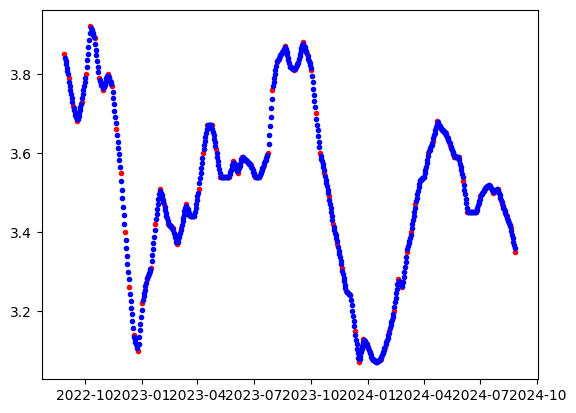

In [ ]:
# graph coloring those with index in x_values with red and those in missing_values with blue
plt.plot(df_augmented['Date'][x_values], df_augmented['Regular'][x_values], 'r.')
plt.plot(df_augmented['Date'][missing_values], df_augmented['Regular'][missing_values], 'b.')
plt.show()

The above image are the gas prices. In red are the known values and in blue are the estimated values using linear regression. How will we do something similar with quadratic? 

In [ ]:
# Lagrange interpolation formula
def Lagrange_basis(x:float, x_vals:list[float], i:int) -> float:
    """Return l_i(x), the basis element for Lagrange interpolation, as a callable function"""
     
    l_i_at_x = 1
    for j in range(len(x_vals)):
        if j != i:
            l_i_at_x *= (x - x_vals[j]) / (x_vals[i] - x_vals[j]) 

    return l_i_at_x # returns l_i(x) for a specified value of x



In [ ]:
# test the basis computation 
x_vals = [-2, -1, 1, 2]
l_0 = Lagrange_basis(1, x_vals, 0) #at x=1
print(l_0 == 0)


True


In [ ]:
# Lagrange polynomial -- return our estimated y-value based on the points given 
def Lagrange_polynomial(x:float, x_vals:list[float], y_vals:list[float]) -> float:
    """Return the y-value of the Lagrange polynomial at x"""
    
    # check that len(x_vals) == len(y_vals)
    if len(x_vals) != len(y_vals):
        raise ValueError("The lengths of x_vals and y_vals is not the same")
    
    y_approx = 0
    for i in range(len(y_vals)):
        y_approx += y_vals[i] * Lagrange_basis(x, x_vals, i)

    return y_approx

In [ ]:
# test 
x_vals = [-2, -1, 1, 2]
y_vals = [-8, -1, 1, 8]
y_approx = Lagrange_polynomial(0, x_vals, y_vals)
print(y_approx == 0)

True


In [ ]:
def fill_missing_values_with_local_quadratic_function(x:np.array, y:np.array, x_approx:float) -> float: 
    """Returns approximate y value using a local quadratic Lagrange polynomial
    
    Parameters: 
        x (np.array): x values
        y (np.array): y values
        x_approx (float): x value to approximate

    Returns:
        float: y_approx (float)
    """

    # find the closest point above x_approx
    x_above_vals = np.sort(x[np.where(x - x_approx > 0)])
    x_above = x_above_vals[0]
    y_above = y[np.where(x == x_above)][0]

    # find the closest point below x_approx
    x_below_vals = np.sort(x[np.where(x - x_approx < 0)])
    x_below = x_below_vals[-1]
    y_below = y[np.where(x == x_below)][0]

    # find third closest point
    x_third = x[np.argsort(np.abs(x - x_approx))[2]]
    y_third = y[np.where(x == x_third)][0]

    # compute the missing value using Lagrange 
    y_approx = Lagrange_polynomial(x_approx, [x_below, x_third, x_above], [y_below, y_third, y_above])
    
    return y_approx


